# DEMs and maps

A digital elevation model (DEM) is a digital representation of Earth's topography and/or bathymetry (or the topography of another planetary body). We can work with DEMs in some of the same ways that we've worked with image. There are important distinctions, however, because DEMs include information about the relationship between pixel coordinates on the screen and geographic coordinates on Earth.

If you've never encountered the concepts of coordinate systems and coordinate transformations, it may  help to read the documentation from ESRI (the company that makes ArcGIS) [Here](http://resources.esri.com/help/9.3/arcgisengine/dotnet/89b720a5-7339-44b0-8b58-0f5bf2843393.htm)

Key Terms:
- **Geographic Coordinate Systems** specify locations on an ellipsoidal planet using latitude, longitude, and elevation above some datum. The datum defines a reference elevation (like sea level) in three-dimensional space.
- **Projected Coordinate Systems** is defined on a flat, 2D coordinate system. Representing images and lines in a projected coordinate system always results in some distortion of features.


In [1]:
# Note - this will be somewhat slow since the DEM is about 100 MB
import numpy as np
from skimage import io
dem = io.imread('output_be.tif')
# Print the maximum and minimum values
print('maximum: ',dem.max())
print('minimum: ',dem.min())
# print shape
print('Shape: ',dem.shape)

maximum:  1.70141e+38
minimum:  377.19156
Shape:  (4544, 5650)


## Note on 'missing' data: 
It is very common to receive digital elevation models with some very large positive of negative values that represent 'no data'. It appears that in our image, the maximum value indicates missing data. Let's replace all of these values with NaN (not a number) for the sake of plotting.

In [2]:
import numpy as np
mask = dem == dem.max()
dem[mask] = np.nan

In [3]:
# prepare a preliminary plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(dem,cmap='terrain')
h=plt.colorbar(fraction=0.035, pad=0.04,label='Elevation (m)')
plt.xlabel('Columns (pixel coordinates)')
plt.ylabel('Rows (pixel coordinates)')
plt.show()

<Figure size 800x800 with 2 Axes>

In [4]:
# As an example, extract a cross-section across the DEM.
start = [500,3500] # Easting (m), Northing (m)


In [5]:
# Now, note that our .tiff image is actually a GEOTIFF. This means that it has geographic information built-in
import cartopy.crs as ccrs
import rasterio
raster = rasterio.open('output_be.tif','r') # open for reading
dem1 = raster.read() # read the DEM

print(dem1.shape)
# Note that the shape is 1x4544x5650. Commonly geotiffs are [channels]x[rows]x[cols]. We need to reshape this to manipulate it further.
dem1 = dem1.reshape(dem1.shape[1:]) # cut out the first dimension
# Print out the meta-data. This contains information about the value used to fill missing data and some other things.
print(raster.meta)

(1, 4544, 5650)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 1.70141e+38, 'width': 5650, 'height': 4544, 'count': 1, 'crs': CRS.from_epsg(26910), 'transform': Affine(1.0, 0.0, 443856.5,
       0.0, -1.0, 4400276.5)}


# Coordinate Reference Systems

Geospatial information in images is often encoded using something called EPSG codes, which stands for the European Petroleum Standards Group. The group provides a set of numerical codes that describe a coordinate system. In this case, we can see that the 'crs' entry within the raster's meta-data contains CRS.from_epsg(26910) which tells us that the EPSG code for the coordinate system is 26910. We can see some information about this coordinate system by googling 'EPSG 26910', or by using a site like epsg.io: [https://epsg.io/26910](https://epsg.io/26910).

When we go to epsg.io, what we learn is that this is a UTM (Universal Transverse Mercator) projection referenced to the NAD83 (North American Datum of 1983). The datum describes the three dimensional shape of the surface that defines zero sea level, and the UTM projection is a **Projected Coordinate System** commonly used to make maps. The UTM coordinate system allows us to express location on a map using distances east and north of a reference point, with easting and northing measured in meters.

There is good documentation on dealing with the conversions between pixels and locations here: https://rasterio.readthedocs.io/en/stable/quickstart.html#dataset-georeferencing

(443856.5, 4400276.5)
(449506.5, 4395732.5)


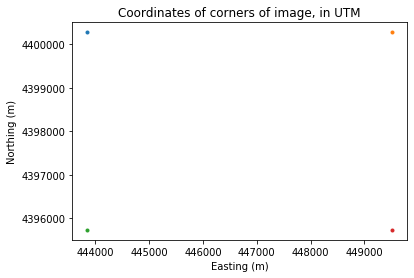

In [6]:
# Get more information about the coordinates
upper_left = raster.transform * (0,0)
lower_right = raster.transform * (raster.width,raster.height)

upper_right = raster.transform * (raster.width,0)
lower_left = raster.transform * (0,raster.height)

print(upper_left)
print(lower_right)
xmin=upper_left[0]
xmax=lower_right[0]
ymin=lower_right[1]
ymax=upper_left[1]

plt.figure()
plt.plot(upper_left[0],upper_left[1],'.')
plt.plot(upper_right[0],upper_right[1],'.')
plt.plot(lower_left[0],lower_left[1],'.')
plt.plot(lower_right[0],lower_right[1],'.')
plt.title('Coordinates of corners of image, in UTM')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.show()

# Display the image with lat/lon coordinate information:

<IPython.core.display.Javascript object>


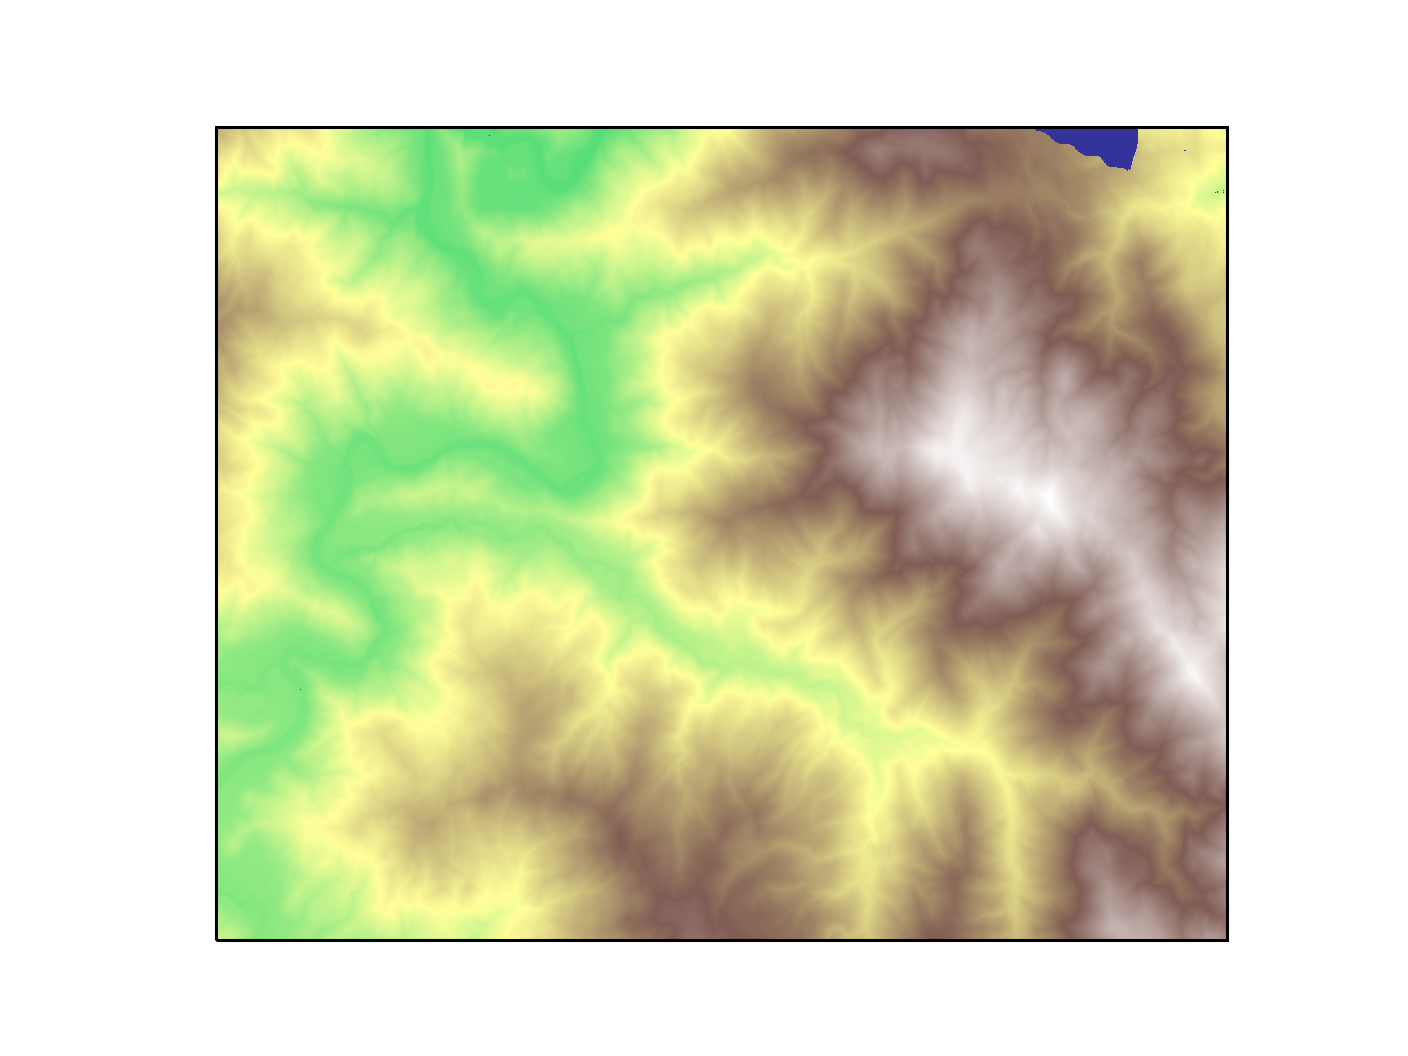

In [7]:
# Display the map, using UTM coordinates
# Fill no-data values (with -1 here)
mask = dem1 == raster.nodata
dem1[mask] = -1

crs = ccrs.UTM(10) # I determined UTM Zone using epsg.io
%matplotlib notebook
ax = plt.axes(projection=crs)
plt.imshow(dem1, origin='upper', cmap='terrain',extent=[xmin, xmax, ymin, ymax], transform=crs, interpolation='nearest')
plt.show()

# Display the image in UTM easting/northing

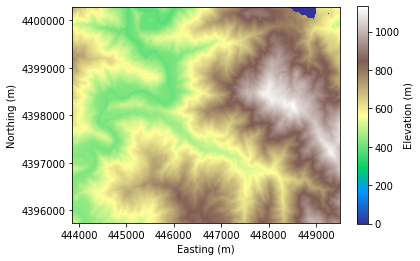

In [15]:
x_values = np.linspace(lower_left[0],lower_right[0],raster.width)
y_values = np.linspace(upper_left[1],lower_right[1],raster.height)
%matplotlib inline

fig,ax = plt.subplots(1,1)
cm = plt.get_cmap('terrain')
h=ax.pcolorfast(x_values,y_values,dem1,cmap=cm)
plt.colorbar(h,label='Elevation (m)')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_aspect('equal','box')
plt.show()


# Draw a line of section (A-A')

<IPython.core.display.Javascript object>


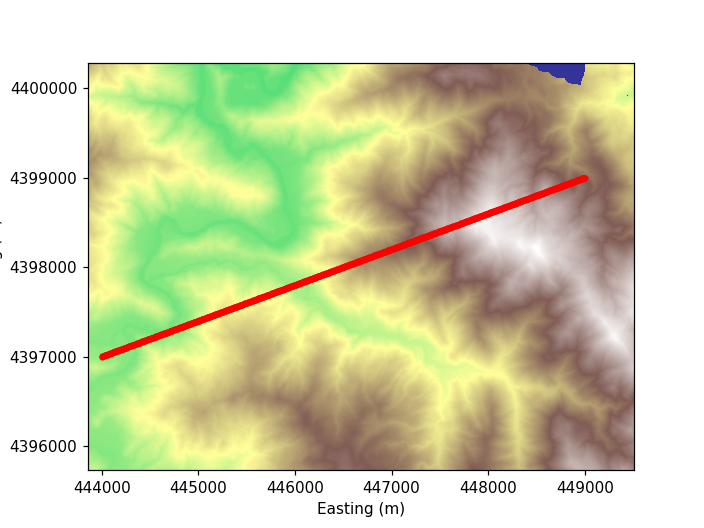

In [12]:
A = [444000,4397000]
Ap = [449000,4399000]
n = 1000
%matplotlib notebook
x_path = np.linspace(A[0],Ap[0],n)
y_path = np.linspace(A[1],Ap[1],n)
fig,ax = plt.subplots(1,1)
cm = plt.get_cmap('terrain')
ax.pcolormesh(x_values,y_values,dem1,cmap=cm)
ax.plot(x_path,y_path,'r.')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
#ax.axis('equal')
plt.show()


In [25]:
# Calcualte the projected coordinates associated with row, col index
print('x,y for [0,0]: ',
      raster.xy(0,0))
print('x,y for [width-1,height-1]: ',
      raster.xy(raster.height-1,raster.width-1))
# Calculate the row,col index associated with x,y coordinates
print('row,col for (x,y)=(443857.0, 4400276.0): ',
      raster.index(443857.0, 4400276.0))

x,y for [0,0]:  (443857.0, 4400276.0)
x,y for [width-1,height-1]:  (449506.0, 4395733.0)
row,col for (x,y)=(443857.0, 4400276.0):  (0, 0)


<IPython.core.display.Javascript object>


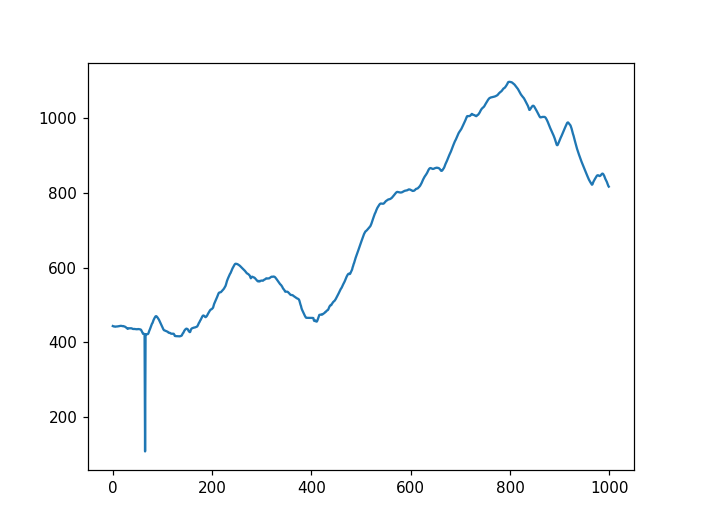

In [13]:
from scipy.interpolate import interp2d
# flip up and down in DEM so that y values are ascending
dem2 = np.flipud(dem1)
y2 = np.flip(y_values)
f = interp2d(x_values,y2,dem2)
z_path = []
for i in range(len(x_path)):
    z_path.append( f(x_path[i],y_path[i]))

plt.figure()
plt.plot(z_path)
plt.show()

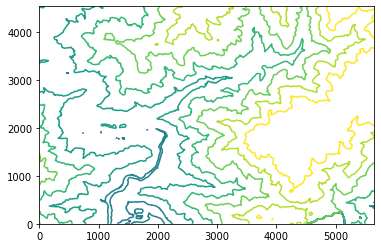

In [14]:
# Contour plots/maps
%matplotlib inline
plt.figure()
levels = np.arange(0,1000,100) # 100 meter contour interval
plt.contour(dem1,levels)
plt.show()
